In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [49]:
results_dirs = {
    "mtsNFVS": "../benchmark/results-nfvs/",
    "AEON.py": "../benchmark/results-aeon/",
    "biobalm": "../benchmark/results-0.2.0/",
}

nk3_fnames = {  # will make others when they are ready
    "all": "random-nk3.csv",
    "biobalm-expand": "random-nk3-full-expand.csv",
    "biobalm-search": "random-nk3-full-attractors.csv",
}

colors = {
    "mtsNFVS": "tab:blue",
    "AEON.py": "tab:orange",
    "biobalm": "tab:green",
}

In [18]:
df_test = pd.read_csv(
    results_dirs["AEON.py"] + nk3_fnames["all"],
    header=None,
    skiprows=1,
    names=["Benchmark", "Time[s]", "Notes"],
)
df_test["Time[s]"]

count     2100
unique      86
top          1
freq      1047
Name: Time[s], dtype: object

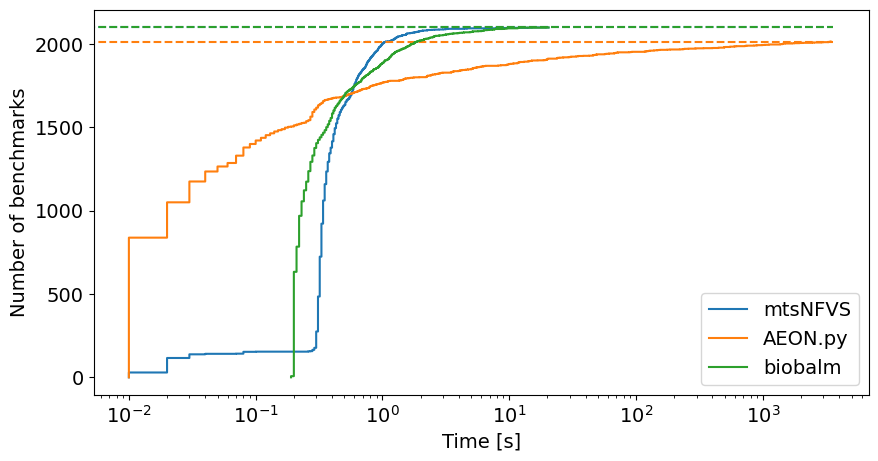

In [75]:
def plot_cumulative(dirs, fnames, colors):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.set_facecolor("white")

    for tool, dir in dirs.items():
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            )
            t = df["Time[s]"].sort_values()
        elif tool == "AEON.py":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "v1", "v2"],
            )
            df["Time[s]"] = df["Time[s]"].apply(
                lambda x: float("inf") if x == " FAIL" else float(x)
            )
            t = df["Time[s]"].sort_values()
        elif tool == "biobalm":
            df_exp = pd.read_csv(
                dirs[tool] + fnames["biobalm-expand"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "_1", "_2", "_3"],
            )
            df_att = pd.read_csv(
                dirs[tool] + fnames["biobalm-search"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "_1", "_2", "_3", "_4"],
            )

            t = (df_exp["Time[s]"] + df_att["Time[s]"]).sort_values()
        else:
            print(f"SKIPPING {tool}")
            continue
        successes = sum(t < float("inf"))
        ax.hlines(
            y=successes, xmin=0, xmax=3600, color=colors[tool], linestyle="dashed"
        )
        ax.step(t, np.arange(len(t)), label=tool, c=colors[tool])

    ax.set_xscale("log")

    ax.set_xlabel("Time [s]", fontsize=14)
    ax.set_ylabel("Number of benchmarks", fontsize=14)

    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14, loc="lower right")


plot_cumulative(results_dirs, nk3_fnames, colors)

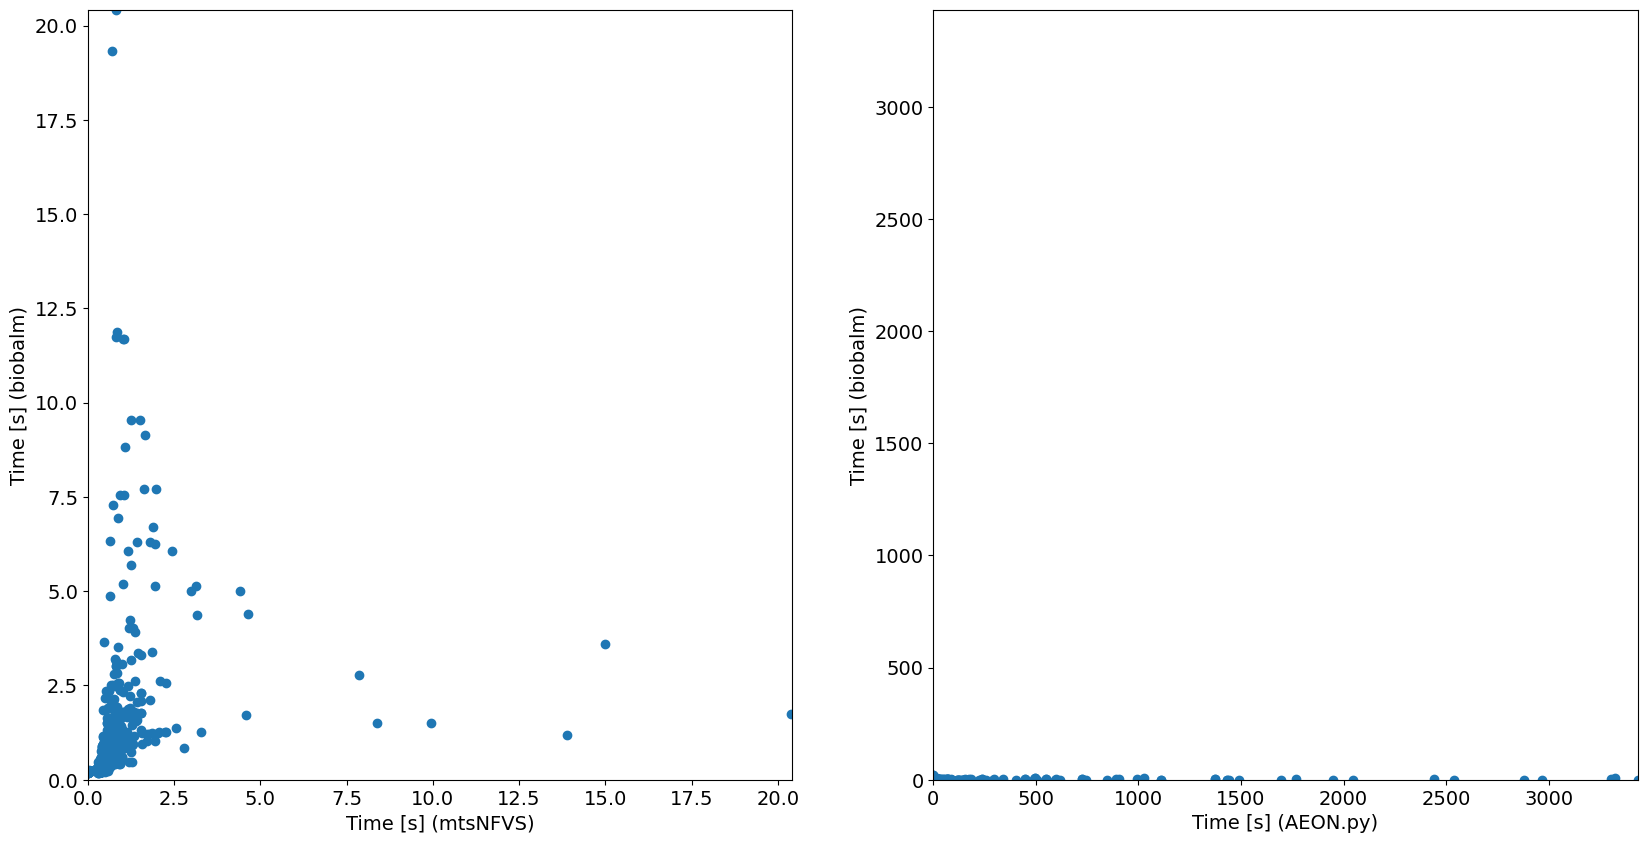

In [86]:
def plot_scatter(dirs, fnames, colors):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    fig.set_facecolor("white")

    for ax, tool in zip(axs.flatten(), ["mtsNFVS", "AEON.py"]):
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            )
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "AEON.py":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "v1", "v2"],
            )
            df["Time[s]"] = df["Time[s]"].apply(
                lambda x: float("inf") if x == " FAIL" else float(x)
            )
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        else:
            continue
        df_exp = pd.read_csv(
            dirs["biobalm"] + fnames["biobalm-expand"],
            header=None,
            skiprows=1,
            names=["Benchmark", "Time[s]", "_1", "_2", "_3"],
        )
        df_exp.sort_values(by="Benchmark", inplace=True)
        df_att = pd.read_csv(
            dirs["biobalm"] + fnames["biobalm-search"],
            header=None,
            skiprows=1,
            names=["Benchmark", "Time[s]", "_1", "_2", "_3", "_4"],
        )
        df_att.sort_values(by="Benchmark", inplace=True)
        t_bb = df_exp["Time[s]"] + df_att["Time[s]"]

        ax.scatter(t, t_bb)

        tmax = max(t[t < float("inf")].max(), t_bb[t_bb < float("inf")].max())
        ax.set_xlim(0, tmax)
        ax.set_ylim(0, tmax)
        # ax.set_xscale("log")

        ax.set_xlabel(f"Time [s] ({tool})", fontsize=14)
        ax.set_ylabel("Time [s] (biobalm)", fontsize=14)

        ax.tick_params(labelsize=14)


plot_scatter(results_dirs, nk3_fnames, colors)